In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
DATA_DIRECTORY = "data/"

# Dataset

The dataset is downloaded from https://covid19.uis.unesco.org/data/. It is composed of worldwide data collected by UNESCO on school closure status and measure taken to ensure education. Data ranges from 16/02/2020 to 31/12/2021. Along with data about the country identification and classifications (United Nations Economic Group, SGD group and World Bank income grouping) the status of each school is recorded and, if closed the type of measures taken, such as TV, radio and internet, are registered.

Additionally the number of students enrolled and the number of children in school age is specified.

In [2]:
data = pd.read_csv(os.path.join(DATA_DIRECTORY, "UNESCO_school_closures_database.csv"),
                   parse_dates=[0])

/tmp/ipykernel_3230/2558796223.py:1: DtypeWarning: Columns (11,12,13,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(os.path.join(DATA_DIRECTORY, "UNESCO_school_closures_database.csv"),


In [3]:
# lowercase each column name
data = data.rename(str.lower, axis='columns')

# drop unused columns
data = data.drop(columns=["region type 1", "region type 2", "region type 3", "teachers (pre-primary to upper secondary)", 
                   "distance learning modalities (global)", "weeks partially open", "weeks fully closed",
                   "partially open type (as of november 30, 2021)"])

# rename columns to easier names
data = data.rename(columns={
  "country id": "country_id",
  "country": "name",
  "region 1": "un_group",
  "region 2": "sdg_group",
  "region 3": "wb_group",
  "enrolment (pre-primary to tertiary)": "students",
  "school age population (pre-primary to upper secondary)": "children",
  "distance learning modalities (tv)": "tv",
  "distance learning modalities (radio)": "radio",
  "distance learning modalities (online)": "online"
})

## Data exploration

In [4]:
data.head()

,date,country_id,name,un_group,sdg_group,wb_group,status,students,children,tv,radio,online
0,2020-02-16,ABW,Aruba,ECLAC: All countries (UNSDCode:98300),SDG: Latin America and the Caribbean,WB: High income (July 2020),Fully open,21004,16731,No,No,Yes
1,2020-02-17,ABW,Aruba,ECLAC: All countries (UNSDCode:98300),SDG: Latin America and the Caribbean,WB: High income (July 2020),Fully open,21004,16731,No,No,Yes
2,2020-02-18,ABW,Aruba,ECLAC: All countries (UNSDCode:98300),SDG: Latin America and the Caribbean,WB: High income (July 2020),Fully open,21004,16731,No,No,Yes
3,2020-02-19,ABW,Aruba,ECLAC: All countries (UNSDCode:98300),SDG: Latin America and the Caribbean,WB: High income (July 2020),Fully open,21004,16731,No,No,Yes
4,2020-02-20,ABW,Aruba,ECLAC: All countries (UNSDCode:98300),SDG: Latin America and the Caribbean,WB: High income (July 2020),Fully open,21004,16731,No,No,Yes


In [5]:
print(f"Dates ranges from {data.date.min()} to {data.date.max()}")

Dates ranges from 2020-02-16 00:00:00 to 2021-12-31 00:00:00


In [6]:
print(f"There are {len(data.name.unique())} countries in total")

There are 210 countries in total


## Data cleaning

In [7]:
data.isna().any()

date          False
country_id    False
name          False
un_group       True
sdg_group      True
wb_group       True
status        False
students      False
children      False
tv             True
radio          True
online         True
dtype: bool

We have some missing data on some fields. Missing group (`un-group`, `sgd-group`, `wb-group`) isn't a deal-breaker but information on measures (`radio`, `online`, `tv`) are important.

In [8]:
data[data.tv.isna() | data.radio.isna() | data.online.isna()].country_id.unique()

array(['CUW', 'STP'], dtype=object)

In [9]:
data[data.tv.isna() | data.radio.isna() | data.online.isna()].status.unique()

array(['Fully open', 'Closed due to COVID-19', 'Academic break',
       'Partially open'], dtype=object)

Missing data mainly comes from two small countries. We cannot really set it to a particular value since missing values also spans those dates in which schools were closed or partially closed.

In [10]:
data[data.country_id == "CUW"].tv.isna().all()

True

In [11]:
data[data.country_id == "STP"].tv.isna().all()

True

Both countries entries are always not available though so there is much we can do to infer those values.
For simplicity we will just remove those two countries.

In [12]:
data = data[~(data.tv.isna() | data.radio.isna() | data.online.isna())]

## Additional data

### Students and population

Number of students and children are inconsistent: some countries ends up having more students than children in school age. This is definetely because children taken into account are those from pre-primary school to upper-secondary while the number of students goes from pre-primary students to tertiary education students. 

In [13]:
grouped = data.groupby("country_id").first()
print(f"{sum(grouped['students'] > grouped['children'])} entries ends up having more students than children.")

70 entries ends up having more students than children.


To overcome this kind of limitation we will integrate with additional data from [World Bank](https://databank.worldbank.org/source/education-statistics)

In [14]:
additional_data = pd.read_csv(os.path.join(DATA_DIRECTORY, "worldbank.csv"))

# remove ununsed columns
additional_data = additional_data[["Country Code", "Series", "mrv"]]
additional_data.mrv = pd.to_numeric(additional_data.mrv, errors="coerce")
additional_data = additional_data.dropna()
# group data by country and indicators
additional_data = additional_data.groupby(["Country Code", "Series"]).first()
# move indicators to columns
additional_data = additional_data.unstack("Series")
additional_data.columns = additional_data.columns.droplevel()
# rename columns
additional_data.columns = ["ls_f", "ls_m", "p_f", "p_m", "us_f", "us_m", "pop_f", "pop_m"]

# merge data
data = data.join(additional_data, on="country_id").drop(columns=["children", "students"]).dropna()
data.head()

,date,country_id,name,un_group,sdg_group,wb_group,status,tv,radio,online,ls_f,ls_m,p_f,p_m,us_f,us_m,pop_f,pop_m
0,2020-02-16,ABW,Aruba,ECLAC: All countries (UNSDCode:98300),SDG: Latin America and the Caribbean,WB: High income (July 2020),Fully open,No,No,Yes,1769.0,1767.0,4728.0,5088.0,2386.0,2455.0,56000.0,50000.0
1,2020-02-17,ABW,Aruba,ECLAC: All countries (UNSDCode:98300),SDG: Latin America and the Caribbean,WB: High income (July 2020),Fully open,No,No,Yes,1769.0,1767.0,4728.0,5088.0,2386.0,2455.0,56000.0,50000.0
2,2020-02-18,ABW,Aruba,ECLAC: All countries (UNSDCode:98300),SDG: Latin America and the Caribbean,WB: High income (July 2020),Fully open,No,No,Yes,1769.0,1767.0,4728.0,5088.0,2386.0,2455.0,56000.0,50000.0
3,2020-02-19,ABW,Aruba,ECLAC: All countries (UNSDCode:98300),SDG: Latin America and the Caribbean,WB: High income (July 2020),Fully open,No,No,Yes,1769.0,1767.0,4728.0,5088.0,2386.0,2455.0,56000.0,50000.0
4,2020-02-20,ABW,Aruba,ECLAC: All countries (UNSDCode:98300),SDG: Latin America and the Caribbean,WB: High income (July 2020),Fully open,No,No,Yes,1769.0,1767.0,4728.0,5088.0,2386.0,2455.0,56000.0,50000.0


### Media usage

To perform a better analysis we also need to take into account the media usage in each country, namely the number of children who has access to internet, television and radio.

#### Television

from https://globaldatalab.org/areadata/view/tv/?levels=1&interpolation=0&extrapolation=0&nearest_real=0

In [15]:
televisions = pd.read_csv(os.path.join(DATA_DIRECTORY, "households_with_tv.csv"))
# extract most recent value
televisions["tv_perc"] = televisions.apply(lambda r: r[4:].dropna()[-1], axis=1)
# drop unused columns
televisions = televisions[["ISO_Code", "tv_perc"]].set_index("ISO_Code")

Unfortunately a lot of countries have missing data.

In [16]:
isos = set(data.country_id).difference(set(televisions.index))

print(f"{len(isos)} countries without information on television")
data[data.country_id.isin(isos)].groupby("country_id").first()[["name"]].head(10)

62 countries without information on television


,name
country_id,
ABW,Aruba
ARE,United Arab Emirates
ATG,Antigua and Barbuda
AUS,Australia
AUT,Austria
BEL,Belgium
BGR,Bulgaria
BHR,Bahrain
BHS,Bahamas


Along with tiny countries, like Andorra, we also have big countries such as Australia and Arab Emirates. 
Let's see if we can approximate those values by using other countries in the same economical social or geographical group.

In [17]:
# merge televisions data on the dataset
data = data.join(televisions, on="country_id")

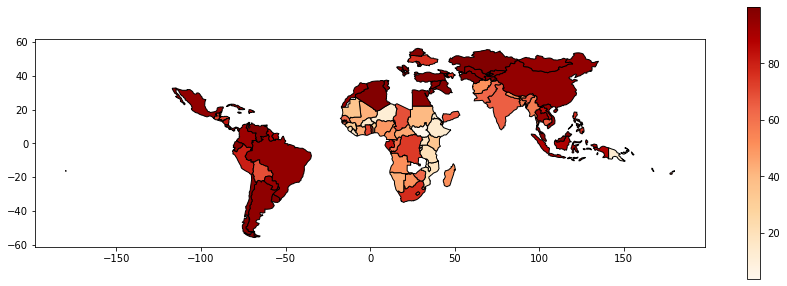

In [18]:
import geopandas
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

world = world.join(data.groupby("country_id").first().tv_perc, on="iso_a3")
world.plot(column="tv_perc", figsize=(15, 5), cmap='OrRd', edgecolor='k', legend=True)
plt.savefig("intial_tv_data")

Indeed a lot of big and important countries are missing. We might try to estimate missing countries tv percentages by taking the median value of those in the same group.

In [20]:
from itertools import combinations
from tqdm.notebook import tqdm

# compute all grouping combinations once
list_combinations = list()
sample_set = set(["un_group", "sdg_group", "wb_group"])
for n in range(1, len(sample_set) + 1):
    list_combinations += list(combinations(sample_set, n))

mse_mean = [[] for _ in list_combinations]
mse_median = [[] for _ in list_combinations]
countries_with_tv = data[~data.tv_perc.isna()]
SAMPLE_SIZE = 100
sampled_countries = np.random.choice(countries_with_tv.country_id.unique(), 
                                     size=SAMPLE_SIZE,
                                     replace=False)

for idx, grouping in tqdm(list(enumerate(list_combinations))):
  for c in sampled_countries:
    # get subset excluding current sample, true value and country groups
    subset = data[data.country_id != c]
    true = data[data.country_id == c].tv_perc.iloc[0] 
    c_group = data[data.country_id == c][list(grouping)].iloc[0]
    
    # filter dataset by grouping values
    grouping_filter = (subset[c_group.index] == c_group).all(axis=1)
    # estimate value using mean and median
    estimated_mean = subset[grouping_filter].groupby("name").first().tv_perc.mean()
    estimated_median = subset[grouping_filter].groupby("name").first().tv_perc.median()
    # compute error
    mse_mean[idx].append((true - estimated_mean)**2)
    mse_median[idx].append((true - estimated_median)**2)
    
  print(f"{str(grouping).ljust(20)} - MSE (mean): {np.mean(mse_mean[idx]):2.2f} MSE (median): {np.mean(mse_median[idx]):2.2f}")

  0%|          | 0/7 [00:00<?, ?it/s]

('un_group',)        - MSE (mean): 506.61 MSE (median): 495.30
('sdg_group',)       - MSE (mean): 451.13 MSE (median): 581.27
('wb_group',)        - MSE (mean): 466.37 MSE (median): 528.23
('un_group', 'sdg_group') - MSE (mean): 419.63 MSE (median): 450.39


/opt/anaconda3/envs/unicef/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/unicef/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


('un_group', 'wb_group') - MSE (mean): nan MSE (median): nan


/opt/anaconda3/envs/unicef/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


('sdg_group', 'wb_group') - MSE (mean): nan MSE (median): nan


/opt/anaconda3/envs/unicef/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/unicef/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


('un_group', 'sdg_group', 'wb_group') - MSE (mean): nan MSE (median): nan


The best method to estimate a country televisions percentage is by using the median of countries in the same *sdg_group* and *un_group*.

<AxesSubplot:>

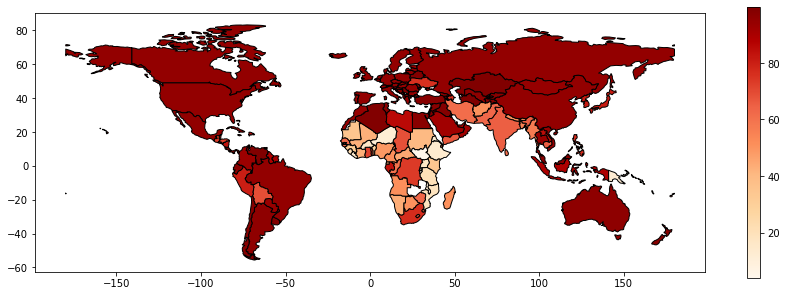

In [37]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world.join(data.groupby("country_id").first().tv_perc, on="iso_a3")
world.plot(column="tv_perc", figsize=(15, 5), cmap='OrRd', edgecolor='k', legend=True)

The result is pretty satisfying but what Australia and New Zealand's low percentage is a bit strange. That is because from Oceania we only have few entries whose percentages are quite low.

We will make use of an external [source](https://www.nationmaster.com/country-info/stats/Media/Households-with-television) and set those countries manually where possible and delete the other.

<AxesSubplot:>

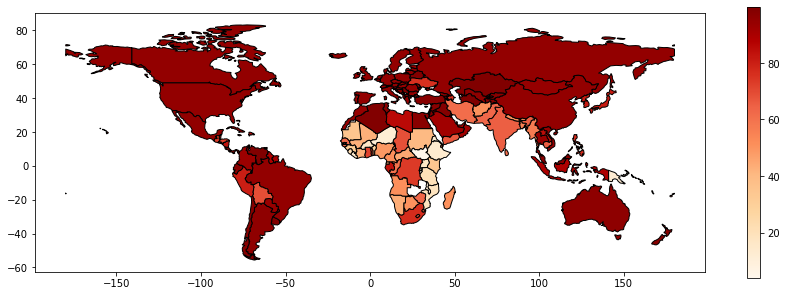

In [38]:
data.loc[data.country_id == "AUS", "tv_perc"] = 96.28
data.loc[data.country_id == "NZL", "tv_perc"] = 98.1

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world.join(data.groupby("country_id").first().tv_perc, on="iso_a3")
world.plot(column="tv_perc", figsize=(15, 5), cmap='OrRd', edgecolor='k', legend=True)

#### Internet

from https://data.worldbank.org/indicator/IT.NET.USER.ZS?view=chart

In [41]:
internet = pd.read_csv(os.path.join(DATA_DIRECTORY, "wolrdbank_internet-users.csv"))
# extract most recent value
internet["internet_perc"] = internet.apply(lambda r: r[4:].dropna()[-1] if len(r[4:].dropna()) else None, axis=1)
# drop unused columns
internet = internet[["Country Code", "internet_perc"]].set_index("Country Code")
# merge data
data = data.join(internet, on="country_id")
data.head()

,date,country_id,name,un_group,sdg_group,wb_group,status,tv,radio,online,ls_f,ls_m,p_f,p_m,us_f,us_m,pop_f,pop_m,tv_perc,internet_perc
0,2020-02-16,ABW,Aruba,ECLAC: All countries (UNSDCode:98300),SDG: Latin America and the Caribbean,WB: High income (July 2020),Fully open,No,No,Yes,1769.0,1767.0,4728.0,5088.0,2386.0,2455.0,56000.0,50000.0,89.523077,97.17
1,2020-02-17,ABW,Aruba,ECLAC: All countries (UNSDCode:98300),SDG: Latin America and the Caribbean,WB: High income (July 2020),Fully open,No,No,Yes,1769.0,1767.0,4728.0,5088.0,2386.0,2455.0,56000.0,50000.0,89.523077,97.17
2,2020-02-18,ABW,Aruba,ECLAC: All countries (UNSDCode:98300),SDG: Latin America and the Caribbean,WB: High income (July 2020),Fully open,No,No,Yes,1769.0,1767.0,4728.0,5088.0,2386.0,2455.0,56000.0,50000.0,89.523077,97.17
3,2020-02-19,ABW,Aruba,ECLAC: All countries (UNSDCode:98300),SDG: Latin America and the Caribbean,WB: High income (July 2020),Fully open,No,No,Yes,1769.0,1767.0,4728.0,5088.0,2386.0,2455.0,56000.0,50000.0,89.523077,97.17
4,2020-02-20,ABW,Aruba,ECLAC: All countries (UNSDCode:98300),SDG: Latin America and the Caribbean,WB: High income (July 2020),Fully open,No,No,Yes,1769.0,1767.0,4728.0,5088.0,2386.0,2455.0,56000.0,50000.0,89.523077,97.17


#### Radio

Unfortunately there isn't much free resources available on how many households do have radio access.
The [following](http://www.unesco.org/new/en/unesco/events/prizes-and-celebrations/celebrations/international-days/world-radio-day-2012/statistics-on-radio/) article from 2012 states that radio reaches the $95\%$ of virtually every segment of the population.
We will set radio access to those value for each country, even though it seems like a naive aproximation.

In [44]:
data["radio_perc"] = 95

# Export data for easier usage

In [45]:
data.to_csv(os.path.join(DATA_DIRECTORY, "data.csv"), index=False)